In [741]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC, Accuracy, SparseCategoricalAccuracy

import matplotlib.pyplot as plt
import numpy as np
import math
import os
import seaborn as sns
from collections import Counter

In [742]:
# Defining Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
COLOR_MODE = 'grayscale'
BATCH_SIZE = 32

### Load Data from Disk

In [744]:
# Load dataset    
ds = tf.keras.utils.image_dataset_from_directory(
  "Xray_Dataset",
  color_mode=COLOR_MODE,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)


# Split dataset 3-ways
train_batches = int(0.6 * len(ds))
val_batches = int(0.21 * len(ds))
train_ds = ds.take(train_batches)
val_ds = ds.skip(train_batches).take(val_batches)
test_ds = ds.skip(train_batches + val_batches)

Found 10080 files belonging to 3 classes.


In [745]:
len(ds)


315

### Data Exploration and Visualization

In [747]:
print(f"Training batches: {len(train_ds)}\nValidation batches: {len(val_ds)}\nTesting batches: {len(test_ds)}")
print(f"Class names: {ds.class_names}")

Training batches: 189
Validation batches: 66
Testing batches: 60
Class names: ['Covid', 'Normal', 'Pneumonia']


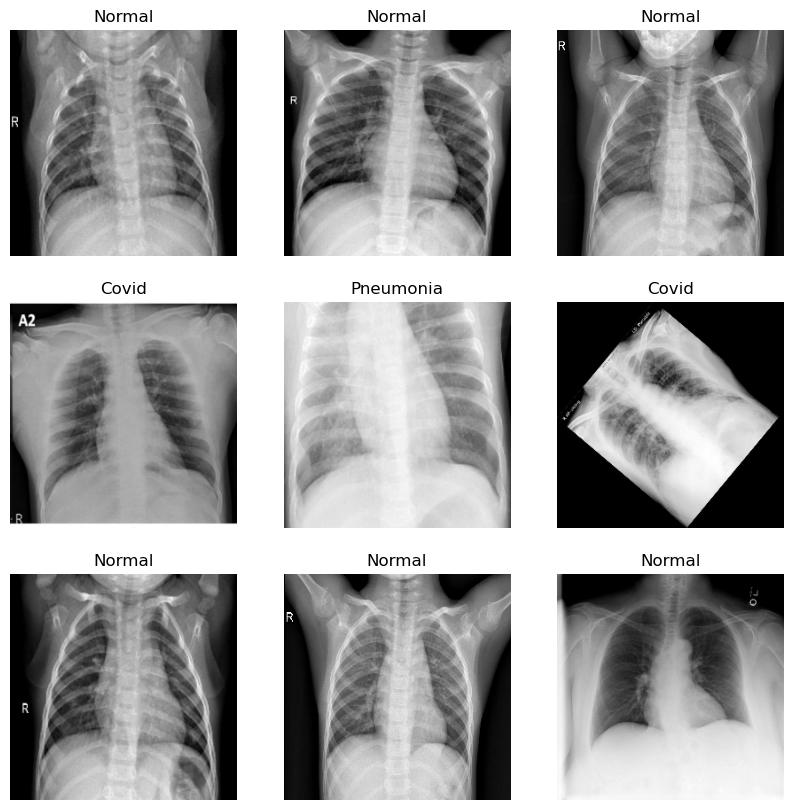

In [748]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

2024-11-04 21:37:48.055181: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


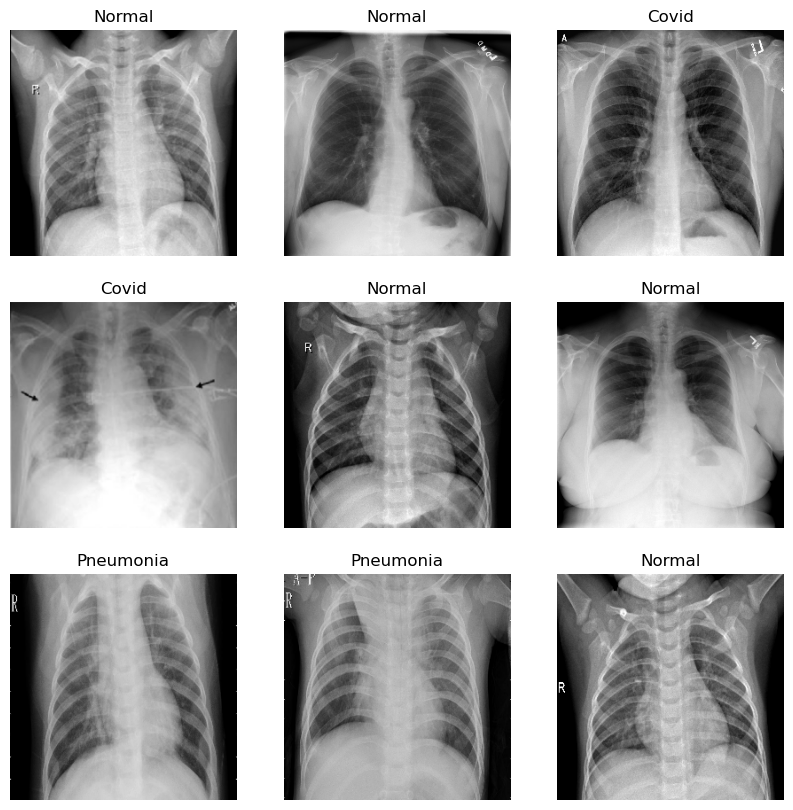

In [749]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [750]:
# Examine label distrubution

# Initialize a Counter
train_ds_label_counts = Counter()
# Iterate through training dataset
for images, labels in train_ds:
    train_ds_label_counts.update(labels.numpy())  # Update counts with current batch labels
    
# Initialize a Counter
val_ds_label_counts = Counter()
# Iterate through validation dataset
for images, labels in val_ds:
    val_ds_label_counts.update(labels.numpy())  # Update counts with current batch labels

# Display total label counts
print("Total label counts in the training dataset:", train_ds_label_counts)
print("Total label counts in the validation dataset:", val_ds_label_counts)

Total label counts in the training dataset: Counter({1: 2054, 2: 2013, 0: 1981})
Total label counts in the validation dataset: Counter({2: 746, 1: 716, 0: 650})


### Preprocess and Normalize Dataset

In [752]:
# Optimize data for performance and GPU utilization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create Model

In [754]:
# Create Model
channel = 1
model = Sequential()
model.add(layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channel)))

# Augment data 
# model.add(layers.RandomRotation(0.1))
# model.add(layers.RandomZoom(0.1))

# Rescale pixel values to 0 - 1
model.add(layers.Rescaling(1./255))

# CNN Layers
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(3, activation='softmax'))


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 128, 128, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,995 (4.01 MB)

 Trainable params: 1,050,995 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

### Fit and Evaluate Model

In [756]:
# Fit Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=30, callbacks=[early_stopping], verbose=1
)

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.6639 - loss: 0.7622 - val_accuracy: 0.8769 - val_loss: 0.3668
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.8804 - loss: 0.3322 - val_accuracy: 0.8958 - val_loss: 0.3217
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.9125 - loss: 0.2569 - val_accuracy: 0.9105 - val_loss: 0.2682
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.9351 - loss: 0.2000 - val_accuracy: 0.9077 - val_loss: 0.2761
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.9431 - loss: 0.1689 - val_accuracy: 0.9223 - val_loss: 0.2428
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.9475 - loss: 0.1488 - val_accuracy: 0.9261 - val_loss: 0.2254
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.9614 - loss: 0.1221 - val_accuracy: 0.9347 - val_loss: 0.2253
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.9705 - loss: 0.0925 - val

In [757]:
# history.history

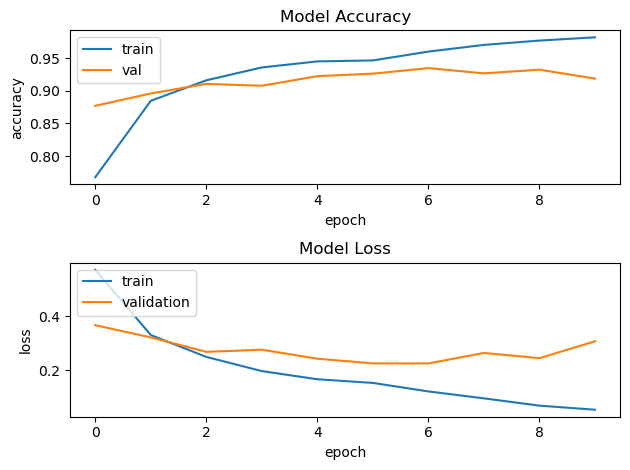

In [758]:
# Plot Performances over epoch

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'val'], loc='upper left')

# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [759]:
pred_classes = model.predict(test_ds)
pred_classes = np.argmax(pred_classes, axis=1)
true_classes = []
# Loop through all batches in the test dataset to collect labels
for images, labels in test_ds:
    true_classes.extend(labels.numpy())
true_classes = np.array(true_classes)
report = classification_report(true_classes, pred_classes, target_names=class_names)
print(report) 

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
              precision    recall  f1-score   support

       Covid       0.97      0.93      0.95       622
      Normal       0.86      0.95      0.90       644
   Pneumonia       0.94      0.88      0.91       654

    accuracy                           0.92      1920
   macro avg       0.92      0.92      0.92      1920
weighted avg       0.92      0.92      0.92      1920



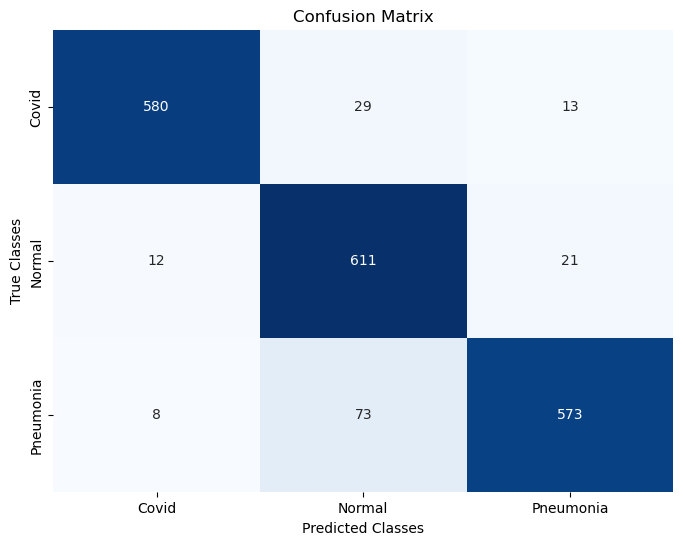

In [760]:
# Plot the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=ds.class_names, yticklabels=ds.class_names)
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()

In [761]:
# # Predict new Xray Image
# img_url = "https://prod-images-static.radiopaedia.org/images/1371188/0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_big_gallery.jpeg"
# img_path = tf.keras.utils.get_file('0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_big_gallery', origin=img_url)

# img = tf.keras.utils.load_img(
#     img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

### References

* *Training Dataset: Kumar, Sachin (2022), “Covid19-Pneumonia-Normal Chest X-Ray Images”, Mendeley Data, V1, doi: 10.17632/dvntn9yhd2.1*
* *PA Dataset: Asraf, Amanullah; Islam, Zabirul (2021), “COVID19, Pneumonia and Normal Chest X-ray PA Dataset”, Mendeley Data, V1, doi: 10.17632/jctsfj2sfn.1*
* *Testing Dataset: Codecademy*